In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import wandb

from data_utils import get_datasets, split_tracks

In [3]:
train_dataset, test_dataset = get_datasets()
_, test_tracks = split_tracks()

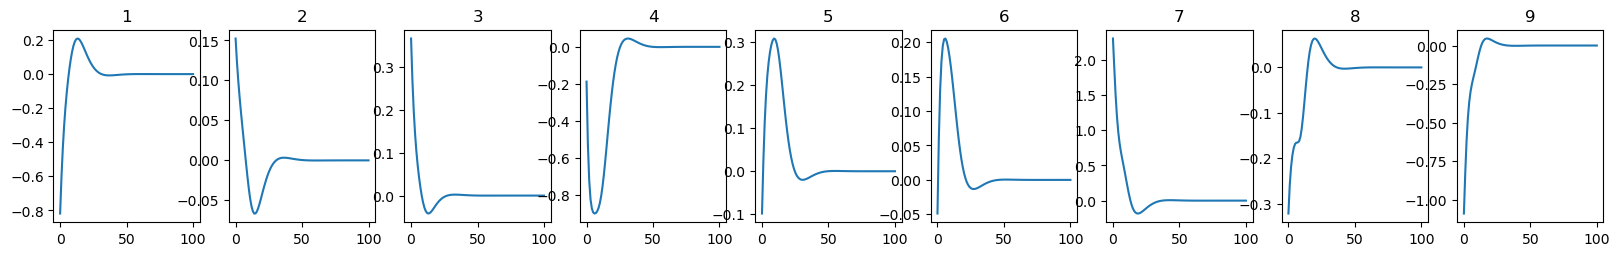

In [4]:
track_index = 3
cur_traj = test_tracks[track_index]

plt.figure(figsize=(20, 2.5))

for i in range(1, 10):
    plt.subplot(1, 9, i)
    plt.plot(cur_traj[:, i-1])
    plt.title(i)

In [5]:
train_loader = DataLoader(train_dataset, 
                          batch_size=64, 
                          shuffle=True,
                          drop_last=True)

test_loader = DataLoader(test_dataset, 
                          batch_size=64)

In [23]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DummyModel2(nn.Module):
    def __init__(self, input_dim=6, 
                 output_dim=3, 
                 hidden_dim_1=16,
                 hidden_dim_2=16,
                 dropout_rate=0) -> None:
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, output_dim)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        return x
    
class DummyModel3(nn.Module):
    def __init__(self, input_dim=6, 
                 output_dim=3, 
                 hidden_dim_1=16,
                 hidden_dim_2=16,
                 hidden_dim_3=16, 
                 dropout_rate=0) -> None:
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, hidden_dim_3)
        self.fc4 = nn.Linear(hidden_dim_3, output_dim)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        x = self.dropout(x)
        x = self.act(x)
        x = self.fc4(x)
        return x

In [24]:
def train_epoch():
    model.train()

    running_loss = 0.
    n_ep_it_loss = 300

    for i, (X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)

        output = model(X)
        loss = criteria(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

def eval_epoch():
    model.eval()
    losses = []
    for i, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            output = model(X)
        loss = criteria(output, y)
        losses.append(loss)

    mean_loss = sum(losses) / len(losses)

    return mean_loss

In [46]:
hidden_dim_1 = 64
hidden_dim_2 = 64
hidden_dim_3 = 64
dropout_rate = 0.3

device = "cuda" if torch.cuda.is_available() else "cpu"

model = DummyModel3(hidden_dim_1=hidden_dim_1, 
                   hidden_dim_2=hidden_dim_2, 
                   hidden_dim_3=hidden_dim_3, 
                   dropout_rate=dropout_rate)
model.to(device)
criteria = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
model

DummyModel3(
  (fc1): Linear(in_features=6, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=3, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [47]:
wandb_loggging = True
if wandb_loggging:
    project_name = "SDRE_Approx"
    run_name = f"Split by tracks; MLP 6-{hidden_dim_1}-{hidden_dim_2}-{hidden_dim_3}-3, dropout={dropout_rate}"
    wandb.login()
    wandb.init(project=project_name,
               name=run_name)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
val_loss,0.00646


In [48]:
# hidden_dim_1 = 64
# hidden_dim_2 = 64
# dropout_rate = 0.

# device = "cuda" if torch.cuda.is_available() else "cpu"
# # model = DummyModel(hidden_dim=256)
# model = DummyModel2(hidden_dim_1=hidden_dim_1, 
#                    hidden_dim_2=hidden_dim_2, 
#                    dropout_rate=dropout_rate)
# model.to(device)
# criteria = nn.MSELoss()
# optimizer = optim.Adam(model.parameters())
# model

In [49]:
# wandb_loggging = True
# if wandb_loggging:
#     project_name = "SDRE_Approx"
#     run_name = f"Split by tracks; MLP 6-{hidden_dim_1}-{hidden_dim_2}-3, dropout={dropout_rate}"
#     wandb.login()
#     wandb.init(project=project_name,
#                name=run_name)

In [50]:
val_loss = eval_epoch()
if wandb_loggging:
    wandb.log({
        "val_loss": val_loss,
        "epoch" : 0
        })

In [52]:
best_loss = 1e6
save_path = f"MLP_3_{hidden_dim_1}_{hidden_dim_2}_{hidden_dim_3}_6_best.pth"

# for epoch in range(100):
for epoch in range(100, 300):
    train_epoch()
    val_loss = eval_epoch()
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), save_path)
        print(f"Improve eval losss on epoch {epoch} = ", best_loss)
        
    if wandb_loggging:
        wandb.log({
            "val_loss": val_loss,
            "epoch" : epoch
            })

Improve eval losss on epoch 100 =  tensor(0.0061)
Improve eval losss on epoch 102 =  tensor(0.0058)
Improve eval losss on epoch 105 =  tensor(0.0058)
Improve eval losss on epoch 252 =  tensor(0.0055)
